In [ ]:
# Reads the "ground truth" mapping from cell id to cell cluster, as provided by Chisel in a TSV file, available at:
# https://github.com/raphael-group/chisel-data/blob/master/patientS0/clones/all/mapping.tsv.gz
# builds a set of healthy cells

print('Reading ground truth clustering and creating Healthy cell list')
cell_to_clone = open('/Users/dd/work/svc/data/mappingB.tsv')
# cell_to_clone.readline()  # skip header (I just deleted the first line instead)

healthy_cell_ids = set()
clone_name_to_idx = {}  # maps Chisel clone names to a 0-based idx, e.g. {'Clone401':0, 'Clone2535':1}
cell_id_to_clone_idx = {}  # stores {cell_id, clone_idx} pairs, e.g. {'A-AAACCTGAGATCTGCT' : 0, 'A-AAACCTGGTACCGCTG':1}
clone_idx = 0

for line in cell_to_clone:
    els = line.split('\t')
    clone_name = els[2]
    cell_id = 'B-' + els[0]
    if els[1] == '19':  # Use '2535' for all cells
        healthy_cell_ids.add(cell_id)
        continue
    if clone_name not in clone_name_to_idx:
        clone_name_to_idx[clone_name] = clone_idx
        clone_idx += 1
    cell_id_to_clone_idx[cell_id] = clone_name_to_idx[clone_name]

print(f'Found {len(healthy_cell_ids)} healthy cells, {len(cell_id_to_clone_idx)} tumor cells')

In [ ]:
import csv

# reading the 40K mutations identified in the Breast Cancer dataset by Chisel (from a TSV file), available at:
# https://github.com/raphael-group/chisel-data/blob/master/patientS0/snvs/cellmutations.tsv.gz
# and then remove all mutations that are also appearing in at least one healthy cell
# Keep only the cell ids that have at least one mutation after this filtering (some tumor cells may only show mutations
# that are in common with at least one healthy cell)

print('Filtering out mutations found in healthy cells')
mutations = []

tsv_all_mut = open('/Users/dd/work/svc/data/cellmutations.tsv')
read_tsv_all_mut = csv.reader(tsv_all_mut, delimiter='\t')
next(read_tsv_all_mut, None)  # skip header

cell_ids_with_mutations = set()

for row in read_tsv_all_mut:
    cell_ids = row[5].split(',')
    cell_ids = [c for c in cell_ids if c.startswith('B-')] # remove this when doing all cells
    healthy_count = 0
    for cell_id in cell_ids:
        if cell_id in healthy_cell_ids:
            healthy_count += 1

    if healthy_count >= 1:
        continue

    chromosome = row[0]
    pos = row[1]
    cell_ids_with_mutations.update(cell_ids)
    mutations.append((chromosome, pos, cell_ids))

print(f'Found {len(cell_ids_with_mutations)} tumor cells that have no mutations in common with healthy cells')
print(f'Found {len(mutations)} cancer mutations: {mutations}')

cell_id_to_idx = {}  # maps cell ids to a 0-based index
cell_idx_to_id = {}  # the inverse of cell_id_to_idx
cell_idx = 0
for cell_id in cell_ids_with_mutations:
    if cell_id in healthy_cell_ids:
        continue
    cell_id_to_idx[cell_id] = cell_idx
    cell_idx_to_id[cell_idx] = cell_id
    cell_idx += 1


In [ ]:
# Generate a mapping that groups multiple cells together based on the Chisel "ground truth"
# This way we can simulate higher coverage in silico

# how many cells of the same type to merge together
merge_count = 12

print(f'Grouping {merge_count} cells together in order to increase coverage')

cell_id_to_group = {}
id_to_count = {}
group_count = 0

for cell_idx in range(len(cell_idx_to_id)):
    cell_id = cell_idx_to_id[cell_idx]
    clone_idx = cell_id_to_clone_idx[cell_id]
    if clone_idx not in id_to_count:
        id_to_count[clone_idx] = []

    id_to_count[clone_idx].append(cell_id)

    if len(id_to_count[clone_idx]) == merge_count:
        for cell_id in id_to_count[clone_idx]:
            cell_id_to_group[cell_id] = group_count
        group_count += 1
        del id_to_count[clone_idx]

print(f'Creating {group_count} complete groups and {len(id_to_count)} incomplete groups')

print(id_to_count.values())

# add incomplete groups
for cells in id_to_count.values():
    for cell_id in cells:
        cell_id_to_group[cell_id] = group_count
    group_count += 1

print(f'Group count is {group_count}')



In [ ]:
print('Creating SBMClone input file...')

sbm_file = open('/Users/dd/work/svc/data/sbm_input', 'w')
all_group_ids = set()
el_count = 0
for count, mutation in enumerate(mutations):
    cell_ids = mutation[2]
    group_ids = set()  # two cells may map to the same group which would cause duplicate entries that upset SBMClone
    for cell_id in cell_ids:
        group_id = cell_id_to_group[cell_id]
        if group_id not in group_ids:
            group_ids.add(group_id)
            sbm_file.write(f'{group_id},{count}\n')
            el_count += 1
    all_group_ids.update(group_ids)

sbm_file.close()
print(
    f'Created SBMClone input file with {len(all_group_ids)} cells, {count + 1} mutations and {el_count} matrix elements')

In [ ]:
# Parse the SBM Clone output (run via 'python ~/work/sbmclone/sbmclone.py sbm_input'), assign the clusters
# to cells and compare to the Chisel ground truth clustering (via the ARI score)

from sklearn.metrics import adjusted_rand_score as ari

print('Mapping back SBMClone output to cell ids and comparing with Chisel ground truth')
sbm_group_clusters = open('/Users/dd/work/svc/data/output/cluster-assignments.txt').readline().split(',')
print(f'SBMClone clustered {len(sbm_group_clusters)} cell groups')
print(f'Expanding group clustering to {len(cell_id_to_clone_idx)} cells...')

sbm_cell_clusters = [None] * len(cell_id_to_idx)
print(cell_id_to_group)
for cell_id, cell_idx in cell_id_to_idx.items():
    sbm_cell_clusters[cell_idx] = sbm_group_clusters[cell_id_to_group[cell_idx_to_id[cell_idx]]]

open(f'/Users/dd/work/svc/data/output/cluster-assignments-per-cell_9x.txt', 'w').write(','.join(sbm_cell_clusters))

print('Evaluating SBMClone performance...')
chisel_clusters = []
for i, cluster in enumerate(sbm_cell_clusters):
    cell_id = cell_idx_to_id[i]
    chisel_clusters.append(cell_id_to_clone_idx[cell_id])
print(f'ARI Score {ari(sbm_cell_clusters, chisel_clusters)}')


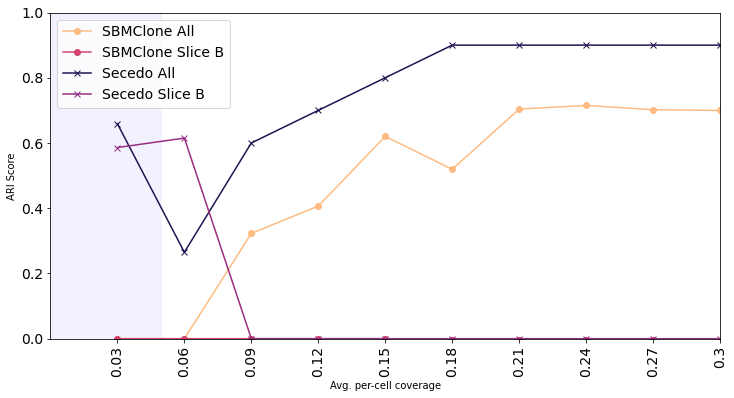

In [9]:
# Plot the SBMClone ARI scores vs the Secedo ARI scores for the breast cancer dataset

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import seaborn as sns


def tick_format(tick, pos):
    print(tick, pos)
    return "bla"


pal = sns.color_palette("magma")

fig, axs = plt.subplots(1, figsize=(12, 6))

xfill = [0, .05]
y1fill = [0, 0]
y2fill = [1, 1]

x_ticks = [0.03, 0.06, 0.09, 0.12, 0.15, 0.18, 0.21, 0.24, 0.27, 0.3]

sbm_clone_all = [-0.0001, -6.321868604628362e-05, 0.3226, 0.4066, 0.6202, 0.5193, 0.704, 0.7150, 0.7021, 0.6996]
sbm_clone_B = [0,0,0,0,0,-0.0031,-0.0031,-0.0031,-0.0031,-0.0091]

secedo_all = [0.659, 0.265, 0.6, 0.7, 0.8, 0.9, 0.9, 0.9, 0.9, 0.9]
secedo_B = [0.586, 0.615, 0, 0, 0, 0, 0, 0, 0, 0]

axs.plot(x_ticks, sbm_clone_all, label="SBMClone All", marker='o', color=pal[5])
axs.plot(x_ticks, sbm_clone_B, label="SBMClone Slice B", marker='o', color=pal[3])
axs.plot(x_ticks, secedo_all, label="Secedo All", marker='x', color=pal[0])
axs.plot(x_ticks, secedo_B, label="Secedo Slice B", marker='x', color=pal[2])

plt.xticks(x_ticks, fontsize=14)
plt.yticks(fontsize=14)

axs.set_ylim([0, 1])
axs.set_xlim([0, 0.3])
axs.xaxis.set_major_locator(ticker.FixedLocator(x_ticks))
axs.xaxis.set_minor_locator(ticker.NullLocator())
axs.xaxis.set_ticklabels(x_ticks, rotation=90)
#axs.grid(True)
axs.legend(loc='best', fontsize=14)

plt.fill_between(xfill, y1fill, y2fill, facecolor='blue', alpha=0.05)
plt.xlabel("Avg. per-cell coverage")

plt.ylabel("ARI Score")

plt.savefig('/tmp/sbm_clone_compare.pdf', format='pdf', bbox_inches='tight')

plt.show()





